In [ ]:
!pip install DMBA mord prince

In [ ]:
%matplotlib inline
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.formula.api as smf
from mord import LogisticIT
import matplotlib.pylab as plt
import seaborn as sns
from dmba import classificationSummary, gainsChart, liftChart
from dmba.metric import AIC_score
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import math
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sys
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import prince
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc
print(sys.version)
print('The scikit-learn version is {}.'.format(sklearn.__version__))

Colab environment detected.
3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]
The scikit-learn version is 1.5.2.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DATA = Path('/content/drive/My Drive/Colab Notebooks/Analytics Competition/')

In [ ]:
train_X = pd.read_csv(DATA / 'train_X.csv')
valid_X = pd.read_csv(DATA / 'valid_X.csv')
train_y = pd.read_csv(DATA / 'train_y.csv')
valid_y = pd.read_csv(DATA / 'valid_y.csv')

train_X.head()

,ApprovalFY,Term,NoEmp,CreateJob,RetainedJob,DisbursementGross,BalanceGross,GrAppv,Franchise_Dummy,RevLineCr_N,...,State_TN,State_VT,State_WA,State_WI,State_WV,IndustryCode_Other,IndustryCode_Real_Estate,UrbanRural_0,UrbanRural_1,UrbanRural_2
0,1996,84,8,0,0,85000.0,0.0,85000.0,0,1,...,0,0,0,0,0,1,0,1,0,0
1,2002,84,7,1,7,50000.0,0.0,50000.0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2005,68,11,0,0,150000.0,0.0,150000.0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,2005,69,15,0,15,11600.0,0.0,11600.0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,1999,240,14,7,7,221000.0,0.0,221000.0,0,1,...,0,0,0,0,0,0,0,1,0,0


###KNN Modeling

Our hardware was struggling with KNN modeling with this dataset due to its large size. To aid with this, we implemented Multiple Component Analysis (MCA). While originally considering Principle Component Analysis (PCA), PCA is tyipcally used for continous data onyl. However, MCA works well for our highly dimensional dataset with binary dummies. MCA aims to reduce the dimensionality of a dataset while keeping most of the information. New varaibles called "components" are created which are actually the original features as new combinations. This will help the efficency of our KNN modeling.

In [ ]:
numerical_features = ['ApprovalFY', 'Term', 'NoEmp', 'CreateJob', 'RetainedJob', 'DisbursementGross',
                      'BalanceGross', 'GrAppv']
categorical_features = ['Franchise_Dummy', 'RevLineCr_N', 'RevLineCr_Other', 'RevLineCr_Y',
                        'LowDoc_N', 'LowDoc_Other', 'LowDoc_Y', 'NewExist_Existing',
                        'NewExist_New', 'NewExist_Other', 'State_GA_NV', 'State_IL_MI',
                        'State_NJ_SC_NY_MD', 'State_TX_CA_DE_KY_VA', 'State_CO_IN_MA',
                        'State_UT_WY_ND_SD', 'Industry_Finan_Trans', 'Industry_Edu_Info_Admin',
                        'Industry_Const_Retail', 'Industry_Food_Arts', 'Industry_Other_Whole_Prof',
                        'Industry_Util_Manu_Pub', 'Industry_Health_Mgmt_Mining_Agri', 'State_AK',
                        'State_AL', 'State_AR', 'State_AZ', 'State_CT', 'State_DC', 'State_FL',
                        'State_HI', 'State_IA', 'State_ID', 'State_KS', 'State_LA', 'State_ME',
                        'State_MN', 'State_MO', 'State_MS', 'State_MT', 'State_NC', 'State_NE',
                        'State_NH', 'State_NM', 'State_OH', 'State_OK', 'State_OR', 'State_PA',
                        'State_RI', 'State_TN', 'State_VT', 'State_WA', 'State_WI', 'State_WV',
                        'IndustryCode_Other', 'IndustryCode_Real_Estate', 'UrbanRural_0',
                        'UrbanRural_1', 'UrbanRural_2']

mca = prince.MCA(n_components=5, n_iter=3, copy=True, check_input=True, engine='sklearn', random_state=42)
train_X_mca = mca.fit_transform(train_X[categorical_features])
valid_X_mca = mca.transform(valid_X[categorical_features])

scaler = StandardScaler()
train_X_num_scaled = scaler.fit_transform(train_X[numerical_features])
valid_X_num_scaled = scaler.transform(valid_X[numerical_features])

train_X_combined = pd.concat([pd.DataFrame(train_X_mca),
                             pd.DataFrame(train_X_num_scaled, columns=numerical_features, index=train_X.index)], axis=1)
valid_X_combined = pd.concat([pd.DataFrame(valid_X_mca),
                             pd.DataFrame(valid_X_num_scaled, columns=numerical_features, index=valid_X.index)], axis=1)

In [ ]:
train_X_combined.columns = train_X_combined.columns.astype(str)
valid_X_combined.columns = valid_X_combined.columns.astype(str)

Determine Best K value for Recall:

Despite letting this code run for several hours on multiple occasions, the computaional load is too high. Given the right resources we would run this code prior to determinnig the best K value. Due to this unablity, we will simply assume that 1 was the best-provided value.

In [ ]:
#results = []
#for k in range(1, 15):
   # knn = KNeighborsClassifier(n_neighbors=k).fit(train_X_combined, train_y.values.ravel())
   # results.append({
       # 'k': k,
      #  'score': recall_score(valid_y, knn.predict(valid_X_combined))
  #  })

#results = pd.DataFrame(results)
#print(results.sort_values(by='score', ascending=False))

We will be using a Kneighbors Classifier as opposed to a Regressor. The classifier is used for discrete predictions while the regressor is used for continuous.

In [ ]:
k = 1

knn = KNeighborsClassifier(n_neighbors=k).fit(train_X_combined, train_y.values.ravel())
predictions = knn.predict(valid_X_combined)

accuracy = accuracy_score(valid_y, predictions)
precision = precision_score(valid_y, predictions)
recall = recall_score(valid_y, predictions)
f1 = f1_score(valid_y, predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

Accuracy: 0.8906235229351677
Precision: 0.6985060581108105
Recall: 0.660155009211613
F1-Score: 0.6787892643972859


**Roc Curve:**

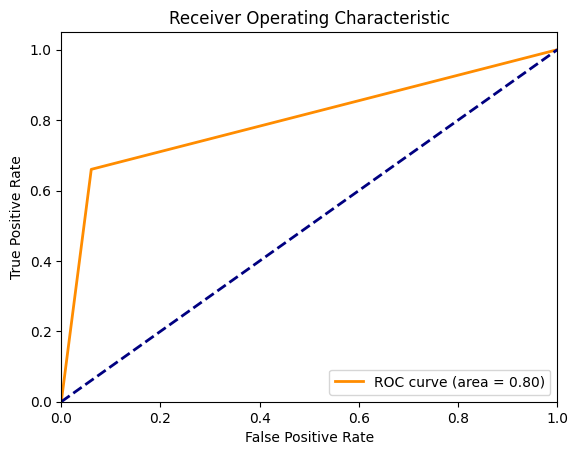

In [ ]:
y_probs = knn.predict_proba(valid_X_combined)[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(valid_y, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

This ROC curve suggests that the model is reasonably good at classification, with an AUC of 0.80 indicating solid performance.

Cut Off Determination:

In [ ]:
best_cutoff_knn = 0
best_f1_score = 0

for cutoff in np.arange(0.01, 1, 0.01):
    predictions = (y_probs >= cutoff).astype(int)

    f1 = f1_score(valid_y['Default_CHGOFF'], predictions)

    if f1 > best_f1_score:
        best_f1_score = f1
        best_cutoff_knn = cutoff

print(f"Best cutoff for KNN (F1-score): {best_cutoff_knn}")

Best cutoff for KNN (F1-score): 0.01


Conclusions:

Due to the high computational demands of KNN, it was very difficult to experiemnt and fine tune our model. As we can see from the cutoff value produced, this model is not at all applicable in a real world context. From the accuracy measures produced in the model we were able to obtain, we see this model does not preform as well as our other modeling techniques so far. As far as real world application, this would be very difficult to manage for high amounts of new loan data. So regardless of the model quality, KNNs inherent difficult nature makes it not be the ideal modeling method.